In [1]:
import pandas as pd

import numpy as np
import scipy as sp

from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [2]:
import gensim
import sklearn

In [3]:
import google.generativeai as genai
import os
from dotenv import load_dotenv
load_dotenv()

GEMINI_API_KEY =  os.getenv('GEMINI_API_KEY')
genai.configure(api_key=GEMINI_API_KEY)
# model = genai.GenerativeModel("gemini-1.5-flash")
model = genai.GenerativeModel(f"tunedModels/medquadmedicalqnadatasetfiltered-8p4omv4")


d:\1UGM\SEM 5\COURSES\STBI\Tugas Akhir\healthcare-chatbot-using-qa-with-word-embedding-ir\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df_medquad = pd.read_csv("MedQuad-MedicalQnADataset.csv")
df_medquad.head()

,Unnamed: 0,qtype,Question,Answer
0,0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


In [5]:
df_pubmed = pd.read_csv("PubMed_200k_RCT/train.csv")
df_pubmed.head()

,abstract_id,line_id,abstract_text,line_number,total_lines,target
0,24491034,24491034_0_11,The emergence of HIV as a chronic condition me...,0,11,BACKGROUND
1,24491034,24491034_1_11,This paper describes the design and evaluation...,1,11,BACKGROUND
2,24491034,24491034_2_11,This study is designed as a randomised control...,2,11,METHODS
3,24491034,24491034_3_11,The intervention group will participate in the...,3,11,METHODS
4,24491034,24491034_4_11,The program is based on self-efficacy theory a...,4,11,METHODS


# Preprocessing

In [6]:
df_pubmed = df_pubmed.dropna(subset=['abstract_text'])  # Remove rows with NaN in abstract_text
df_pubmed = df_pubmed.sort_values(by=['line_id'])
df_pubmed = df_pubmed.groupby('abstract_id').agg({'abstract_text':' '.join}).reset_index()
df_pubmed.head()

,abstract_id,abstract_text
0,1279170,We conducted this study to assess the clinical...
1,1281030,To determine whether prophylactic treatment wi...
2,1282364,After the discovery of type C hepatitis virus ...
3,1283117,Since it is not clear whether testosterone or ...
4,1283730,The aim was to study the pharmacokinetic param...


In [7]:
# add qa id to medquad
df_medquad['qa_id'] = range(1, len(df_medquad) + 1)
df_medquad = df_medquad[['qa_id', 'Question', 'Answer', 'qtype']]
df_medquad.head()

,qa_id,Question,Answer,qtype
0,1,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...,susceptibility
1,2,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...,symptoms
2,3,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...,susceptibility
3,4,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos...",exams and tests
4,5,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen...",treatment


In [8]:
train_medquad, test_medquad = train_test_split(df_medquad, test_size=0.2, random_state=42)

# Word Embedding

In [27]:
# Calculate the size of each part
part_size = len(df_pubmed) // 4

# Split using iloc
df_pubmed_1 = df_pubmed.iloc[0:part_size]
df_pubmed_2 = df_pubmed.iloc[part_size:part_size*2]
df_pubmed_3 = df_pubmed.iloc[part_size*2:part_size*3]
df_pubmed_4 = df_pubmed.iloc[part_size*3:]

# Verify the splits
print(f"Original df_pubmed length: {len(df_pubmed)}")
print(f"Part 1 length: {len(df_pubmed_1)}")
print(f"Part 2 length: {len(df_pubmed_2)}")
print(f"Part 3 length: {len(df_pubmed_3)}")
print(f"Part 4 length: {len(df_pubmed_4)}")

Original df_pubmed length: 190654
Part 1 length: 47663
Part 2 length: 47663
Part 3 length: 47663
Part 4 length: 47665


In [28]:
df_pubmed_1

,abstract_id,abstract_text
0,1279170,We conducted this study to assess the clinical...
1,1281030,To determine whether prophylactic treatment wi...
2,1282364,After the discovery of type C hepatitis virus ...
3,1283117,Since it is not clear whether testosterone or ...
4,1283730,The aim was to study the pharmacokinetic param...
...,...,...
47658,12814449,To characterize the population pharmacokinetic...
47659,12814453,"Nafcillin ( Wyeth Laboratories , Philadelphia ..."
47660,12814457,Whether chronic dosing with montelukast confer...
47661,12814458,To compare the metabolic and vascular effects ...


### Biobert

In [34]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load BioBERT
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

def get_biobert_embedding(text):
    """
    Get BioBERT embedding for a text
    
    Args:
        text (str): Input text
    Returns:
        numpy.ndarray: Embedding vector
    """
    # Tokenize text
    inputs = tokenizer(text, return_tensors="pt", max_length=512, 
                      truncation=True, padding=True)
    
    # Get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        # Use [CLS] token embedding or mean of all tokens
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    
    return embeddings

# Replace the Word2Vec functions
def get_sentence_vector(sentence):
    """
    Get embedding vector for a sentence using BioBERT
    """
    return get_biobert_embedding(sentence)

# Update the dataframe processing
def process_embeddings(df):
    """
    Process embeddings for all texts in dataframe
    """
    print("Generating embeddings...")
    
    # Convert texts to embeddings
    df['abstract_vector'] = df['abstract_text'].progress_apply(get_biobert_embedding)
    
    if 'Question' in df.columns:
        df['question_vector'] = df['Question'].progress_apply(get_biobert_embedding)
    
    return df

In [35]:
from tqdm.notebook import tqdm
from tqdm import tqdm
import pandas as pd

# Add tqdm to pandas
tqdm.pandas()

def process_embeddings(df):
    """
    Process embeddings for all texts in dataframe
    """
    print("Generating embeddings...")
    
    # Convert texts to embeddings
    df['abstract_vector'] = df['abstract_text'].apply(get_biobert_embedding)
    
    if 'Question' in df.columns:
        df['question_vector'] = df['Question'].apply(get_biobert_embedding)
    
    return df

In [36]:
# Take 10 random samples from df_pubmed
df_pubmed_1_10 = df_pubmed.sample(n=10, random_state=42)

In [40]:
# Take 10 random samples from df_pubmed
train_medquad_10 = train_medquad.sample(n=10, random_state=42)

In [41]:
train_medquad_10

,qa_id,Question,Answer,qtype
12909,12910,What are the treatments for Granuloma annulare ?,How might granuloma annulare be treated? Granu...,treatment
4133,4134,What is (are) Insomnia ?,Espaol\n \nInsomnia (in-SOM-ne-...,information
9093,9094,What is (are) hypophosphatasia ?,Hypophosphatasia is an inherited disorder that...,information
13925,13926,What are the symptoms of Alpha-ketoglutarate d...,What are the signs and symptoms of Alpha-ketog...,symptoms
15177,15178,What are the symptoms of Battaglia-Neri syndro...,What are the signs and symptoms of Battaglia-N...,symptoms
3801,3802,How to diagnose Heart Attack ?,Several tests are used to diagnose a heart att...,exams and tests
11761,11762,What is (are) Achondrogenesis type 1A ?,Achondrogenesis is a group of severe disorders...,information
12011,12012,What is (are) Tyrosinemia type 3 ?,Tyrosinemia type 3 is a genetic disorder chara...,information
585,586,what research (or clinical trials) is being do...,The NINDS supports a broad program of research...,research
8881,8882,Is Horner syndrome inherited ?,Horner syndrome is usually not inherited and o...,inheritance


In [37]:
df_pubmed_1_10

,abstract_id,abstract_text
181312,24985195,In patients with ulnar neuropathy at the elbow...
128734,21263351,To demonstrate the effectiveness of medical-gr...
58248,15450833,"A prospective , randomized , double-blinded cl..."
31064,11176769,Past research has documented that primary care...
34665,11504982,Therapy with a HIV protease inhibitor is assoc...
40951,12136395,Diabetic nephropathy is associated with a high...
35067,11550163,The Stockholm II trial is a population-based p...
175566,24554005,We aimed to study the relationship between mea...
151199,22880805,Central venous catheter ( CVC ) - related bloo...
87528,17716952,Although school-based behavioral interventions...


In [38]:
process_embeddings(df_pubmed_1_10)

Generating embeddings...


,abstract_id,abstract_text,abstract_vector
181312,24985195,In patients with ulnar neuropathy at the elbow...,"[0.25288826, -0.15218946, 0.12070046, 0.016255..."
128734,21263351,To demonstrate the effectiveness of medical-gr...,"[0.06274251, -0.19161001, 0.0038936865, 0.1763..."
58248,15450833,"A prospective , randomized , double-blinded cl...","[0.0867315, -0.11562394, 0.05665308, 0.1818021..."
31064,11176769,Past research has documented that primary care...,"[0.08944352, -0.22997476, -0.073201366, 0.1056..."
34665,11504982,Therapy with a HIV protease inhibitor is assoc...,"[0.23046726, 0.099457584, -0.1309958, 0.101070..."
40951,12136395,Diabetic nephropathy is associated with a high...,"[0.10740273, -0.06814235, -0.10095524, 0.03936..."
35067,11550163,The Stockholm II trial is a population-based p...,"[0.052613325, 0.019460566, -0.043198172, 0.128..."
175566,24554005,We aimed to study the relationship between mea...,"[0.13681157, 0.043099456, -0.09748603, 0.14177..."
151199,22880805,Central venous catheter ( CVC ) - related bloo...,"[0.17658867, 0.013130028, -0.057806622, 0.1050..."
87528,17716952,Although school-based behavioral interventions...,"[0.092342794, 0.010948917, -0.06422814, 0.2813..."


In [42]:
process_embeddings(train_medquad_10)

Generating embeddings...


Exception ignored in: <function tqdm.__del__ at 0x00000245C39F6C00>
Traceback (most recent call last):
  File "d:\1UGM\SEM 5\COURSES\STBI\Tugas Akhir\healthcare-chatbot-using-qa-with-word-embedding-ir\.venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "d:\1UGM\SEM 5\COURSES\STBI\Tugas Akhir\healthcare-chatbot-using-qa-with-word-embedding-ir\.venv\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x00000245C39F6C00>
Traceback (most recent call last):
  File "d:\1UGM\SEM 5\COURSES\STBI\Tugas Akhir\healthcare-chatbot-using-qa-with-word-embedding-ir\.venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "d:\1UGM\SEM 5\COURSES\STBI\Tugas Akhir\healthcare-chatbot-using-qa-with-word-embedding-ir\.venv\Lib\site-packages\tqdm\notebook.py", line 279, in 

KeyError: 'abstract_text'

In [39]:
# Check length of abstract vectors
print("Length of first abstract vector:", len(df_pubmed_1_10['abstract_vector'].iloc[0]))

# Verify all vectors have same length
vector_lengths = df_pubmed_1_10['abstract_vector'].apply(len)
print("\nAll vectors have same length:", all(vector_lengths == vector_lengths.iloc[0]))
print("Vector lengths:", vector_lengths.unique())


Length of first abstract vector: 768

All vectors have same length: True
Vector lengths: [768]


# Information Retrieval

In [51]:
def find_top_k_abstracts(query_vector, abstract_vectors_col, k=3, df=df_pubmed):
    cosine_scores = cosine_similarity([query_vector], np.array(df[abstract_vectors_col]).tolist())[0]
    top_k_indices = np.argsort(cosine_scores)[-k:][::-1]
    return df.iloc[top_k_indices]['abstract_id'].values, cosine_scores[top_k_indices]

def find_top_k_answers(df, query_vector, question_vectors_col, k=3):
    cosine_scores = cosine_similarity([query_vector], np.array(df[question_vectors_col]).tolist())[0]
    top_k_indices = np.argsort(cosine_scores)[-k:][::-1]
    return df.iloc[top_k_indices]['qa_id'].values, cosine_scores[top_k_indices]

def get_qa_pairs(df, qa_ids):
    return df[df['qa_id'].isin(qa_ids)][['qa_id', 'Question', 'Answer']]


def get_abstracts(abstract_ids):
    return df_pubmed[df_pubmed['abstract_id'].isin(abstract_ids)][['abstract_id', 'abstract_text']]

def query_top_k_answers_and_abstracts(df, query, k=10):
    query_vector = get_sentence_vector(query)

    qa_ids, question_scores = find_top_k_answers(df, query_vector, 'question_vector', k)
    abstract_ids, abstract_scores = find_top_k_abstracts(query_vector, 'abstract_vector', k)

    answers_df = get_qa_pairs(df, qa_ids)
    abstracts_df = get_abstracts(abstract_ids)

    answers_df['Similarity Score'] = question_scores
    abstracts_df['Similarity Score'] = abstract_scores

    return answers_df, abstracts_df

In [52]:
queries = [
    "What is the incubation period of COVID-19?",
    "Cure for fever?",
    "Who is at risk for Lymphocytic Choriomeningit",
    "What are the symptoms of Ligma?"
]

In [53]:
for query in queries:
    print(f"Query: {query}")
    answers_df, abstracts_df = query_top_k_answers_and_abstracts(train_medquad, query)
    print("Top Answers:")
    display(answers_df)
    print("Top Abstracts:")
    display(abstracts_df)
    print("\n")

Query: What is the incubation period of COVID-19?
Top Answers:


,qa_id,Question,Answer,Similarity Score
10753,10754,What is (are) dyskeratosis congenita ?,Dyskeratosis congenita is a disorder that can ...,0.647081
252,253,what is the treatment for vancomycin-resistant...,On this Page General Information What is vanco...,0.637043
11895,11896,What is (are) Anonychia congenita ?,Anonychia congenita is an extremely rare nail ...,0.637043
15727,15728,What is (are) Pachyonychia congenita ?,Pachyonychia congenita (PC) is a rare inherite...,0.637043
8918,8919,What is (are) pachyonychia congenita ?,Pachyonychia congenita is a condition that pri...,0.637043
7678,7679,What is (are) paramyotonia congenita ?,Paramyotonia congenita is a disorder that affe...,0.637043
10058,10059,What is (are) Waldenstrm macroglobulinemia ?,Waldenstrm macroglobulinemia is a rare blood c...,0.637043
392,393,What is the outlook for Agenesis of the Corpus...,Prognosis depends on the extent and severity o...,0.633984
12772,12773,What is (are) Paramyotonia congenita ?,Paramyotonia congenita is an inherited conditi...,0.631612
728,729,What is the outlook for Neurosyphilis ?,Prognosis can change based on the type of neur...,0.630091


Top Abstracts:


,abstract_id,abstract_text,Similarity Score
8088,8612858,To establish whether time to down-regulation a...,0.685417
26428,10748773,Irrigation suction drainage ( ISD ) is an addi...,0.684163
44142,12526238,Heart rate has been used to measure infants ' ...,0.683375
50652,14601817,The purpose of this study was to investigate w...,0.682391
59581,15561795,To measure the impact of a computerized guidel...,0.676083
93172,18295761,To determine the optimum time interval between...,0.674333
96992,18577202,Two types of methods are used to assess learni...,0.672660
122779,20696729,The goal was to assess the feasibility of earl...,0.672455
139950,22068638,Near infrared ( NIR ) spectroscopy is a techno...,0.672451
186231,25432920,Does culture in a closed system result in an i...,0.671429




Query: Cure for fever?
Top Answers:


,qa_id,Question,Answer,Similarity Score
1327,1328,What are the treatments for Myotonia ?,"Treatment for myotonia may include mexiletine,...",0.604811
9647,9648,What are the treatments for Parkinson disease ?,These resources address the diagnosis or manag...,0.604055
10887,10888,What are the treatments for myotonia congenita ?,These resources address the diagnosis or manag...,0.604055
9412,9413,What are the treatments for retinitis pigmento...,These resources address the diagnosis or manag...,0.601695
919,920,What are the treatments for Leukodystrophy ?,Treatment for most of the leukodystrophies is ...,0.601124
9122,9123,What are the treatments for Alzheimer disease ?,These resources address the diagnosis or manag...,0.601097
10822,10823,"What are the treatments for neuropathy, ataxia...",These resources address the diagnosis or manag...,0.599236
2383,2384,What are the treatments for Indigestion ?,Some people may experience relief from symptom...,0.599236
827,828,What are the treatments for Metachromatic Leuk...,There is no cure for MLD. Bone marrow transpla...,0.599208
1081,1082,What are the treatments for Myotonia Congenita ?,Most people with myotonia congenita dont requi...,0.599208


Top Abstracts:


,abstract_id,abstract_text,Similarity Score
199,1392793,To evaluate the effect of short term treatment...,0.575126
39499,12000378,"Tinea capitis , a common clinical pattern of d...",0.558888
48212,12856053,To compare the parasitological and clinical ef...,0.556633
68373,16240515,To determine whether a single dose of Clindess...,0.555034
79903,17173219,Bacterial vaginosis ( BV ) is the most common ...,0.553726
84386,17504616,Applying three treatment methods for enuresis ...,0.546881
94626,18401974,At the present the clinical treatment of choic...,0.545302
110092,19663597,Treatment of visceral leishmaniasis ( VL ) is ...,0.543007
139580,22039269,The aim of this study is to evaluate the effec...,0.540354
177295,24673608,Long-duration beta-lactam antibiotics are used...,0.538211




Query: Who is at risk for Lymphocytic Choriomeningit
Top Answers:


,qa_id,Question,Answer,Similarity Score
3921,3922,Who is at risk for Parkinson's Disease? ?,"About 60,000 Americans are diagnosed with Park...",1.000000
1576,1577,Who is at risk for Diverticular Disease? ?,Diverticulosis becomes more common as people a...,0.951077
4546,4547,Who is at risk for Bronchopulmonary Dysplasia? ?,The more premature an infant is and the lower ...,0.947501
4161,4162,Who is at risk for Alpha-1 Antitrypsin Deficie...,Alpha-1 antitrypsin (AAT) deficiency occurs in...,0.943087
4379,4380,Who is at risk for Hemolytic Anemia? ?,Hemolytic anemia can affect people of all ages...,0.942907
3135,3136,Who is at risk for Chronic Lymphocytic Leukemi...,Older age can affect the risk of developing ch...,0.942187
2,3,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...,0.938165
2761,2762,Who is at risk for Parathyroid Cancer? ?,Having certain inherited disorders can increas...,0.935887
4312,4313,Who is at risk for Electrocardiogram? ?,An electrocardiogram (EKG) has no serious risk...,0.918098
4492,4493,Who is at risk for Thrombocythemia and Thrombo...,Primary Thrombocythemia\n \nThr...,0.918098


Top Abstracts:


,abstract_id,abstract_text,Similarity Score
28829,10975790,1-2 % of all patients under non-steroidal anti...,0.811170
33487,11403365,The Hypertension Optimal Treatment ( HOT ) Stu...,0.794185
61870,15742336,The efficacy of allogeneic hematopoietic stem ...,0.790489
116096,20139767,This study evaluates the Alzheimer disease ris...,0.784338
117211,20216073,To determine whether family medical history as...,0.783373
152881,22992357,"Family Healthware , a tool developed by the CD...",0.782582
153661,23046591,Atrial fibrillation ( AF ) is the most common ...,0.781664
177495,24686885,There is little evidence to inform the targete...,0.781331
183666,25188543,Civilian posttraumatic stress disorder ( PTSD ...,0.780802
186701,25467619,To determine the perceived risk of type 2 diab...,0.780116




Query: What are the symptoms of Ligma?
Top Answers:


,qa_id,Question,Answer,Similarity Score
14104,14105,What are the symptoms of Phacomatosis pigmento...,What are the signs and symptoms of phacomatosi...,1.0
13641,13642,What are the symptoms of Camptodactyly taurinu...,What are the signs and symptoms of Camptodacty...,1.0
15548,15549,What are the symptoms of Coccygodynia ?,What signs and symptoms are associated with co...,1.0
14526,14527,What are the symptoms of GM1 gangliosidosis ?,What are the signs and symptoms of GM1 ganglio...,1.0
13644,13645,What are the symptoms of Tetramelic monodactyly ?,What are the signs and symptoms of Tetramelic ...,1.0
15074,15075,What are the symptoms of Syringoma ?,What are the signs and symptoms of Syringoma? ...,1.0
1787,1788,What are the symptoms of Cystocele ?,The symptoms of a cystocele may include\n ...,1.0
15997,15998,What are the symptoms of Microhydranencephaly ?,What are the signs and symptoms of Microhydran...,1.0
16349,16350,What are the symptoms of Microtia-Anotia ?,What are the signs and symptoms of Microtia-An...,1.0
11302,11303,What are the symptoms of D-glycericacidemia ?,What are the signs and symptoms of D-glycerica...,1.0


Top Abstracts:


,abstract_id,abstract_text,Similarity Score
13777,9300508,The majority of patients presenting to cardiac...,0.770450
32707,11329526,Although the patient experiences the symptoms ...,0.759774
59762,15572868,"According to homeopathic theory , symptoms pro...",0.756948
64519,15938885,To investigate the states of chronic symptoms ...,0.756407
81392,17291177,Expectancy and modeling have been cited as fac...,0.755323
87981,17805217,Generalized anxiety disorder ( GAD ) is a chro...,0.753190
99741,18806203,"Occasional leg symptoms , like feelings of hea...",0.751274
102943,19127072,Subjects with atopic syndrome often perceive s...,0.749022
117119,20211300,The timely and accurate identification of symp...,0.748671
144191,22364776,Tobacco withdrawal symptoms may be confounded ...,0.747349


# Pass Context to LLM

In [54]:
# def call_llm(context, query):
#     prompt = f"Answer the following medical question based on the provided context."

#     prompt += f"\nQuestion: {query}\n"

#     prompt += "\nRelevant Medical QA Pairs::\n"
#     for i, qa in enumerate(context['answers'], 1):
#         prompt += f"\nQA Pair {i}:\nQ: {qa['Question']}\nA: {qa['Answer']}\n"
    
#     prompt += "\nRelevant Medical Research Abstracts:\n"
#     for i, abstract in enumerate(context['abstracts'], 1):
#         prompt += f"\nAbstract {i}:\n{abstract['abstract_text']}\n"
    
#     prompt += "\nBased on the above context, do not make up an answer and do not use your existing knowledge, please provide a comprehensive answer to the question."

#     response = model.generate_content(prompt)
    
#     return response 

In [55]:
# Changed Prompt
def call_llm(context, query):
    prompt = f"You are a medical expert assistant. Answer the following medical question comprehensively and accurately. If the provided context contains relevant information, use it. If not, use your general medical knowledge to provide the best possible answer."

    prompt += f"\nQuestion: {query}\n"

    prompt += "\nContext:\n"
    prompt += "\nRelevant Medical QA Pairs:\n"
    for i, qa in enumerate(context['answers'], 1):
        prompt += f"\nQA Pair {i}:\nQ: {qa['Question']}\nA: {qa['Answer']}\n"
    
    prompt += "\nRelevant Medical Research Abstracts:\n"
    for i, abstract in enumerate(context['abstracts'], 1):
        prompt += f"\nAbstract {i}:\n{abstract['abstract_text']}\n"
    
    prompt += "\nProvide a clear, direct, and comprehensive answer to the question. Focus on being helpful and informative to the user."

    response = model.generate_content(prompt)
    
    return response 

In [56]:
def process_medical_query(df, query):
    answers_df, abstracts_df = query_top_k_answers_and_abstracts(df, query)
    
    if len(answers_df) == 0 and len(abstracts_df) == 0:
        return {
            'response': "I apologize, but I don't have enough reliable information to answer this question.",
            'confidence': 'low'
        }
    
    context = {
        'answers': answers_df.to_dict(orient='records'),
        'abstracts': abstracts_df.to_dict(orient='records')
    }
    
    llm_response = call_llm(context, query)
    
    return {
        'response': llm_response.text,
        'confidence': 'high'
    }

test_query = "Who is at risk for Lymphocytic Choriomeningit?"
result = process_medical_query(train_medquad, test_query)
print(result['response'])

Persons who handle infected mice are most at risk for lymphocytic choriomeningitis virus (LCMV) infection. A mother can also spread the infection to a developing fetus. Transmission of LCMV typically occurs through contamination with rodent urine, saliva, droppings, or nesting materials. Less frequently, LCMV has been spread via corneal transplants or via laboratory accidents. In most cases, transmission occurs without any symptoms, but in some persons, a subclinical illness may occur. LCMV can also be spread by blood transfusion.


# Evaluation

# Test_Medquad

In [57]:
from nltk.translate.chrf_score import sentence_chrf
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import nltk
import numpy as np
import pandas as pd

def calculate_rouge(prediction, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(prediction, reference)
    return {
        'ROUGE-1': scores['rouge1'].fmeasure,
        'ROUGE-L': scores['rougeL'].fmeasure
    }

def calculate_meteor(prediction, reference):
    pred_tokens = nltk.word_tokenize(prediction.lower())
    ref_tokens = nltk.word_tokenize(reference.lower())
    return meteor_score([ref_tokens], pred_tokens)

def calculate_chrf(prediction, reference):
    return sentence_chrf(reference, prediction, min_len=1, beta=2.0)

def calculate_metrics(predictions, references):
    individual_scores = []
    
    for pred, ref in zip(predictions, references):
        scores = {}
        
        # Calculate ROUGE scores
        rouge_scores = calculate_rouge(pred, ref)
        scores.update(rouge_scores)
        
        # Calculate METEOR score
        scores['METEOR'] = calculate_meteor(pred, ref)
        
        # Calculate chrF2 score
        scores['chrF2'] = calculate_chrf(pred, ref)
        
        individual_scores.append(scores)
    
    # Calculate average scores
    avg_scores = {
        metric: np.mean([s[metric] for s in individual_scores])
        for metric in individual_scores[0].keys()
    }
    
    return avg_scores, individual_scores

def evaluate_llm(test_df, train_medquad, sample_size=10):
    # Sample random questions from test set
    test_sample = test_df.sample(n=sample_size, random_state=42)
    
    questions = test_sample['Question'].tolist()
    true_answers = test_sample['Answer'].tolist()
    
    # Get predictions
    predicted_answers = []
    for question in questions:
        result = process_medical_query(train_medquad, question)
        predicted_answers.append(str(result['response']))
    
    # Calculate all metrics
    avg_metrics, individual_metrics = calculate_metrics(predicted_answers, true_answers)
    
    # Create evaluation dataframe
    eval_data = []
    
    for i, (question, true_ans, pred_ans, metrics) in enumerate(zip(
        questions, true_answers, predicted_answers, individual_metrics)):
        
        eval_data.append({
            'Question': question,
            'True Answer': true_ans,
            'Predicted Answer': pred_ans,
            'True Length': len(true_ans.split()),
            'Predicted Length': len(pred_ans.split()),
            'Length Ratio': len(pred_ans.split()) / len(true_ans.split()),
            **metrics  # Unpack all metrics
        })
    
    # Create DataFrame
    eval_df = pd.DataFrame(eval_data)
    
    # Print detailed results
    print("\nDetailed Evaluation Results:")
    print("\nMetrics Summary:")
    metrics_cols = ['ROUGE-1', 'ROUGE-L', 'METEOR', 'chrF2']
    print(eval_df[metrics_cols].describe())
    
    print("\nLength Analysis:")
    print(f"Average True Answer Length: {eval_df['True Length'].mean():.1f} words")
    print(f"Average Predicted Answer Length: {eval_df['Predicted Length'].mean():.1f} words")
    print(f"Average Length Ratio: {eval_df['Length Ratio'].mean():.1f}x")
    
    return eval_df, avg_metrics

print("Starting evaluation...")
eval_df, avg_metrics = evaluate_llm(test_medquad, train_medquad)

Starting evaluation...


ResourceExhausted: 429 Resource has been exhausted (e.g. check quota).

In [33]:
print("\nEvaluation DataFrame (first few rows):")
display(eval_df[['Question', 'True Answer', 'Predicted Answer', 'ROUGE-1', 'ROUGE-L', 'METEOR', 'chrF2']].head())

print("\nAverage Metrics:")
for metric, score in avg_metrics.items():
    print(f"{metric}: {score:.4f}")


Evaluation DataFrame (first few rows):


,Question,True Answer,Predicted Answer,ROUGE-1,ROUGE-L,METEOR,chrF2
0,How to diagnose Peripheral Artery Disease ?,Peripheral artery disease (P.A.D.) is diagnose...,The diagnosis of renal artery stenosis (RAS) i...,0.100109,0.060936,0.034017,0.064255
1,What is (are) Prostate Cancer ?,Surgery is a common treatment for early stage ...,Prostate cancer is disease in which malignant ...,0.257261,0.149378,0.263074,0.337984
2,What is (are) Drowning ?,People drown when they get too much water in t...,Drowning is a term used to describe death by s...,0.339623,0.166038,0.246327,0.366823
3,What is (are) Long QT syndrome 1 ?,Romano-Ward syndrome is the most common form o...,Long QT syndrome is a disorder of the heart's ...,0.285714,0.179272,0.338480,0.343444
4,What is (are) X-linked adrenal hypoplasia cong...,X-linked adrenal hypoplasia congenita is a dis...,"X-linked adrenal hypoplasia congenita, also ca...",0.473829,0.225895,0.299290,0.489903



Average Metrics:
ROUGE-1: 0.3501
ROUGE-L: 0.1902
METEOR: 0.2582
chrF2: 0.3707


### With Normalization

In [34]:
from nltk.translate.chrf_score import sentence_chrf
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import nltk
import numpy as np
import pandas as pd

def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

def truncate_or_pad_text(text, target_length):
    words = text.split()
    if len(words) > target_length:
        # Truncate to target length
        return ' '.join(words[:target_length])
    return text

def calculate_rouge(prediction, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(prediction, reference)
    return {
        'ROUGE-1': scores['rouge1'].fmeasure,
        'ROUGE-L': scores['rougeL'].fmeasure
    }

def calculate_meteor(prediction, reference):
    pred_tokens = nltk.word_tokenize(prediction.lower())
    ref_tokens = nltk.word_tokenize(reference.lower())
    return meteor_score([ref_tokens], pred_tokens)

def calculate_chrf(prediction, reference):
    return sentence_chrf(reference, prediction, min_len=1, beta=2.0)

def calculate_metrics(predictions, references):
    individual_scores = []
    
    for pred, ref in zip(predictions, references):
        # Normalize texts to lowercase and remove extra whitespace
        pred = ' '.join(pred.lower().split())
        ref = ' '.join(ref.lower().split())
        
        # Calculate length ratio for normalization
        pred_len = len(pred.split())
        ref_len = len(ref.split())
        # Option 1: Use min(pred_len, ref_len) / max(pred_len, ref_len)
        ratio = min(pred_len, ref_len) / max(pred_len, ref_len) if pred_len > 0 else 1
        
        scores = {}
        
        # Calculate ROUGE scores and normalize
        rouge_scores = calculate_rouge(pred, ref)
        scores['ROUGE-1'] = rouge_scores['ROUGE-1'] * ratio
        scores['ROUGE-L'] = rouge_scores['ROUGE-L'] * ratio
        
        # Calculate and normalize METEOR score
        scores['METEOR'] = calculate_meteor(pred, ref) * ratio
        
        # Calculate and normalize chrF2 score
        scores['chrF2'] = calculate_chrf(pred, ref) * ratio
        
        individual_scores.append(scores)
    
    # Calculate average scores
    avg_scores = {
        metric: np.mean([s[metric] for s in individual_scores])
        for metric in individual_scores[0].keys()
    }
    
    return avg_scores, individual_scores

def evaluate_llm(test_df, train_medquad, sample_size=10):
    # Sample random questions from test set
    test_sample = test_df.sample(n=sample_size, random_state=42)
    
    questions = test_sample['Question'].tolist()
    true_answers = test_sample['Answer'].tolist()
    
    # Get predictions
    predicted_answers = []
    for question in questions:
        result = process_medical_query(train_medquad, question)
        predicted_answers.append(str(result['response']))
    
    # Calculate all metrics
    avg_metrics, individual_metrics = calculate_metrics(predicted_answers, true_answers)
    
    # Create evaluation dataframe
    eval_data = []
    
    for i, (question, true_ans, pred_ans, metrics) in enumerate(zip(
        questions, true_answers, predicted_answers, individual_metrics)):
        
        # Normalize texts
        true_ans_norm = normalize_text(true_ans)
        pred_ans_norm = truncate_or_pad_text(
            normalize_text(pred_ans), 
            len(true_ans_norm.split())
        )
        
        eval_data.append({
            'Question': question,
            'True Answer': true_ans,
            'Predicted Answer': pred_ans,
            'Normalized True Answer': true_ans_norm,
            'Normalized Predicted Answer': pred_ans_norm,
            'Original True Length': len(true_ans.split()),
            'Original Predicted Length': len(pred_ans.split()),
            'Normalized Length': len(true_ans_norm.split()),
            **metrics
        })
    
    # Create DataFrame
    eval_df = pd.DataFrame(eval_data)
    
    print("\nDetailed Evaluation Results:")
    print("\nMetrics Summary:")
    metrics_cols = ['ROUGE-1', 'ROUGE-L', 'METEOR', 'chrF2']
    print(eval_df[metrics_cols].describe())
    
    print("\nLength Analysis:")
    print(f"Average Original True Length: {eval_df['Original True Length'].mean():.1f} words")
    print(f"Average Original Predicted Length: {eval_df['Original Predicted Length'].mean():.1f} words")
    print(f"Average Normalized Length: {eval_df['Normalized Length'].mean():.1f} words")
    
    return eval_df, avg_metrics

# Run evaluation
print("Starting evaluation...")
eval_df, avg_metrics = evaluate_llm(test_medquad, train_medquad)


Starting evaluation...

Detailed Evaluation Results:

Metrics Summary:
         ROUGE-1    ROUGE-L     METEOR      chrF2
count  10.000000  10.000000  10.000000  10.000000
mean    0.176045   0.100784   0.124214   0.192469
std     0.097801   0.058458   0.061132   0.103521
min     0.014259   0.008872   0.014238   0.023649
25%     0.123105   0.068840   0.099798   0.157251
50%     0.200001   0.106860   0.149140   0.202951
75%     0.251947   0.131228   0.165751   0.250259
max     0.281118   0.193251   0.182177   0.335465

Length Analysis:
Average Original True Length: 199.0 words
Average Original Predicted Length: 243.8 words
Average Normalized Length: 199.0 words


In [35]:
print("\nEvaluation DataFrame (first few rows):")
display(eval_df[['Question', 'True Answer', 'Predicted Answer', 'ROUGE-1', 'ROUGE-L', 'METEOR', 'chrF2']].head())

print("\nAverage Metrics:")
for metric, score in avg_metrics.items():
    print(f"{metric}: {score:.4f}")


Evaluation DataFrame (first few rows):


,Question,True Answer,Predicted Answer,ROUGE-1,ROUGE-L,METEOR,chrF2
0,How to diagnose Peripheral Artery Disease ?,Peripheral artery disease (P.A.D.) is diagnose...,Peripheral artery disease (P.A.D.) is diagnose...,0.260736,0.193251,0.138813,0.197364
1,What is (are) Prostate Cancer ?,Surgery is a common treatment for early stage ...,Prostate cancer is a disease in which malignan...,0.014259,0.008872,0.026728,0.023649
2,What is (are) Drowning ?,People drown when they get too much water in t...,Drowning is death from suffocation in a liquid...,0.225582,0.109743,0.160239,0.250939
3,What is (are) Long QT syndrome 1 ?,Romano-Ward syndrome is the most common form o...,Long QT Syndrome (LQTS) is a genetic disorder ...,0.185351,0.103977,0.179395,0.208538
4,What is (are) X-linked adrenal hypoplasia cong...,X-linked adrenal hypoplasia congenita is a dis...,X-linked adrenal hypoplasia congenita (AHC) is...,0.107394,0.063414,0.120646,0.154330



Average Metrics:
ROUGE-1: 0.1760
ROUGE-L: 0.1008
METEOR: 0.1242
chrF2: 0.1925


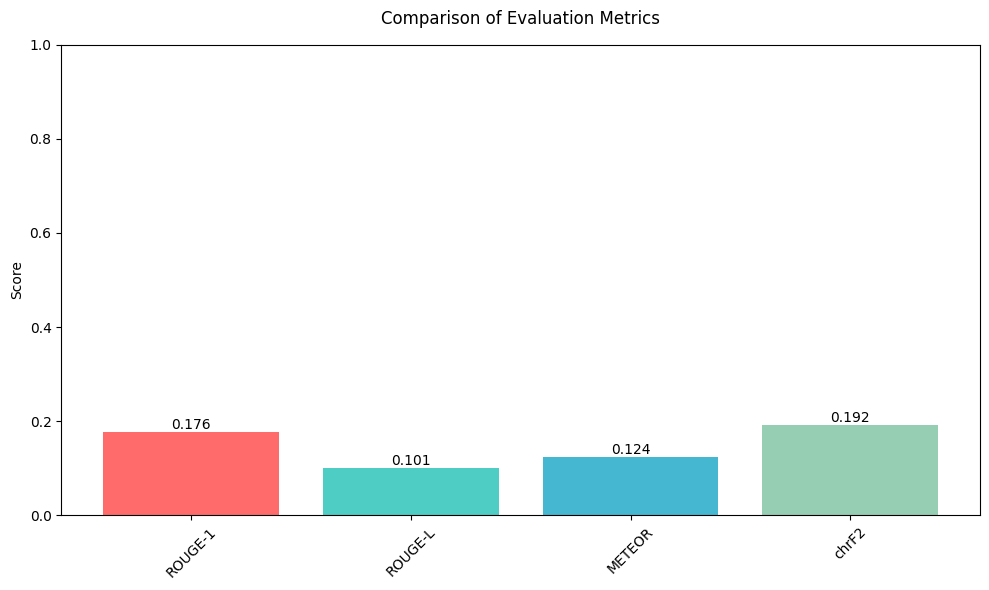

In [37]:
import matplotlib.pyplot as plt

# Extract metrics and scores
metrics = list(avg_metrics.keys())
scores = list(avg_metrics.values())

# Define colors for each metric
colors = {
    'ROUGE-1': '#FF6B6B',    # Coral red
    'ROUGE-L': '#4ECDC4',    # Turquoise
    'METEOR': '#45B7D1',     # Sky blue
    'chrF2': '#96CEB4'       # Sage green
}

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=[colors[metric] for metric in metrics])

# Customize the chart
plt.title('Comparison of Evaluation Metrics', fontsize=12, pad=15)
plt.ylabel('Score', fontsize=10)
plt.ylim(0, 1)  # Metrics typically range from 0 to 1

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()